## LeNet

LeNet由Yann LeCun团队于1998年提出，是首个成功应用于图像识别的卷积神经网络（CNN），主要用于解决手写数字识别问题，尤其在邮政和银行系统中需求迫切。在深度学习兴起前，传统方法依赖人工特征提取，效率低且泛化能力差。此外，神经网络面临梯度消失、数据量不足、计算资源有限等问题。LeNet在MNIST数据集上实现了低于1%的错误率，远超当时其他模型，验证了CNN在图像任务中的有效性。

基础架构：LeNet-5（经典版本）定义了CNN的基本框架：卷积层（局部连接、权值共享）→ 池化层（下采样）→ 全连接层。这一结构至今仍是CNN的基石：
* 卷积操作：通过局部感受野提取空间特征，减少参数量并增强平移不变性。
* 平均池化：降低特征图分辨率，减少计算复杂度。
* 梯度学习：首次将反向传播（Backpropagation）与卷积结合，实现了端到端训练。


后续模型如AlexNet、VGG、ResNet均延续了卷积+池化的堆叠设计，并通过增加深度和参数优化性能。LeNet的权值共享和局部连接思想被广泛应用于目标检测、语义分割等复杂任务。

LeNet不仅是卷积神经网络的里程碑，更是深度学习从理论走向实践的转折点。其创新的架构和训练方法为现代AI模型提供了范式，并在硬件、算法、数据三要素的协同演进中持续发挥影响力。正如LeCun所言：“深度学习的冬天终将过去，而LeNet是春天的第一缕曙光。”

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import time

from hdd.device.utils import get_device
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
DEVICE = get_device(["cuda", "cpu"])
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
print("Use device: ", DEVICE)

Use device:  cuda


## MNIST数据集
我们在MNIST数据集上进行手写数字分类，MNIST提供了$32\times32$的黑白图像，该数据集有60000张训练图片，10000张测试图片。

### 加载数据集

In [2]:
# 我们提前计算好了训练数据集上的均值和方差
MNIST_MEAN = 0.131
MNIST_STD = 0.308
# 加载数据集
train_dataset = datasets.MNIST(
    root=DATA_ROOT,
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([MNIST_MEAN], [MNIST_STD])]
    ),
)
test_dataset = datasets.MNIST(
    root=DATA_ROOT,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([MNIST_MEAN], [MNIST_STD])]
    ),
)
print("Basic Info of train dataaset: \n", train_dataset)
print("Basic Info of test dataset: \n", test_dataset)
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Basic Info of train dataaset: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.131], std=[0.308])
           )
Basic Info of test dataset: 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.131], std=[0.308])
           )


### 可视化数据集
每一列都是属于同一类别的样本

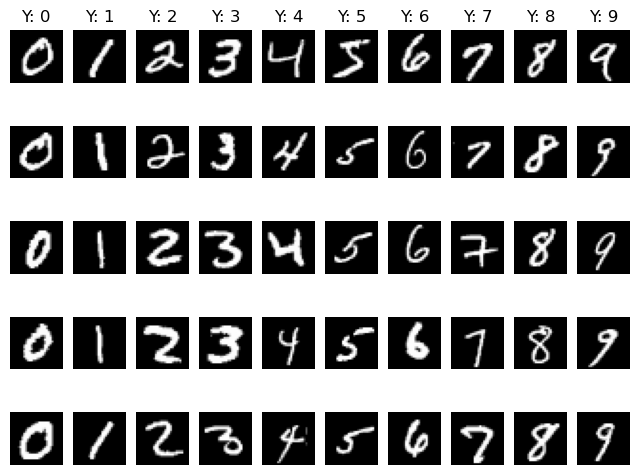

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.rcParams['image.cmap'] = 'gray'
images_per_class = 5
num_classes = 10
train_dataset = train_loader.dataset
for target_class in range(num_classes):
    idxs = torch.nonzero(train_loader.dataset.targets == target_class)
    idxs = idxs[:images_per_class]
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + target_class + 1
        plt.subplot(images_per_class, num_classes, plt_idx)
        image = train_dataset.data[idx,:,:]
        plt.imshow(image.squeeze())
        plt.axis("off")
        if i == 0:
            plt.title(f"Y: {target_class}")
plt.show()

## 训练LeNet

模型的定义在`hdd/models/cnn/lenet.py`中。

首先定义一个简单的训练函数

In [4]:
def train_model(
    net,
    criteria,
    optimizer,
    max_epoches,
    train_loader,
    test_loader,
    device,
    verbose: bool = True,
):
    result = {
        "train_loss": [],
        "test_loss": [],
        "train_accuracy": [],
        "test_accuracy": [],
    }
    for epoch in range(1, max_epoches + 1):
        t0 = time.time()
        train_loss = 0.0
        correct_items = 0
        total_items = 0
        net.train()
        for Xs, ys in train_loader:
            Xs, ys = Xs.to(device), ys.to(device)
            optimizer.zero_grad()
            logits = net(Xs)
            loss = criteria(logits, ys)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct_items += torch.sum(torch.argmax(logits, dim=1) == ys).item()
            total_items += Xs.shape[0]
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_items / total_items

        net.eval()
        correct_items = 0
        total_items = 0
        test_loss = 0.0
        with torch.no_grad():
            for Xs, ys in test_loader:
                Xs, ys = Xs.to(DEVICE), ys.to(DEVICE)
                logits = net(Xs)
                loss = criteria(logits, ys)
                correct_items += torch.sum(torch.argmax(logits, dim=1) == ys).item()
                total_items += Xs.shape[0]
                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = correct_items / total_items
        if verbose:
            print(
                f"Train Epoch: {epoch}/{max_epoches} "
                f"Avg Loss: {avg_train_loss:0.4f} "
                f"Accuracy: {train_accuracy:0.4f} "
                f"Time: {time.time() - t0:0.5f} "
                f" | Test Avg Loss: {avg_test_loss:0.4f} "
                f"Accuracy: {test_accuracy:0.4f}"
            )
        result["train_loss"].append(avg_train_loss)
        result["test_loss"].append(avg_test_loss)
        result["train_accuracy"].append(train_accuracy)
        result["test_accuracy"].append(test_accuracy)
    return result

LeNet中使用了Tanh激活函数，我们这里测试不同的激活函数，尤其是更为现代的ReLU，看看有何异同。

In [5]:
from hdd.models.cnn.lenet import LeNet

MAX_EPOCHES = 20
net = LeNet(num_classes=10, activation=nn.Tanh)
net.to(DEVICE)
criteria = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
tanh_result = train_model(
    net, criteria, optimizer, MAX_EPOCHES, train_loader, test_loader, DEVICE
)

Train Epoch: 1/20 Avg Loss: 1.4621 Accuracy: 0.5785 Time: 2.46739  | Test Avg Loss: 0.6005 Accuracy: 0.8428
Train Epoch: 2/20 Avg Loss: 0.4309 Accuracy: 0.8828 Time: 2.40808  | Test Avg Loss: 0.3250 Accuracy: 0.9100
Train Epoch: 3/20 Avg Loss: 0.2919 Accuracy: 0.9167 Time: 2.33991  | Test Avg Loss: 0.2502 Accuracy: 0.9289
Train Epoch: 4/20 Avg Loss: 0.2292 Accuracy: 0.9336 Time: 2.38962  | Test Avg Loss: 0.2004 Accuracy: 0.9431
Train Epoch: 5/20 Avg Loss: 0.1860 Accuracy: 0.9464 Time: 2.41067  | Test Avg Loss: 0.1648 Accuracy: 0.9524
Train Epoch: 6/20 Avg Loss: 0.1530 Accuracy: 0.9563 Time: 2.41263  | Test Avg Loss: 0.1365 Accuracy: 0.9598
Train Epoch: 7/20 Avg Loss: 0.1279 Accuracy: 0.9638 Time: 2.37598  | Test Avg Loss: 0.1143 Accuracy: 0.9659
Train Epoch: 8/20 Avg Loss: 0.1101 Accuracy: 0.9687 Time: 2.49081  | Test Avg Loss: 0.0968 Accuracy: 0.9716
Train Epoch: 9/20 Avg Loss: 0.0959 Accuracy: 0.9723 Time: 2.34931  | Test Avg Loss: 0.0876 Accuracy: 0.9736
Train Epoch: 10/20 Avg Loss:

In [7]:
net = LeNet(num_classes=10, activation=nn.ReLU)
net.to(DEVICE)
criteria = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
relu_result = train_model(
    net, criteria, optimizer, MAX_EPOCHES, train_loader, test_loader, DEVICE
)

Train Epoch: 1/20 Avg Loss: 2.0767 Accuracy: 0.3332 Time: 2.48977  | Test Avg Loss: 0.8195 Accuracy: 0.7417
Train Epoch: 2/20 Avg Loss: 0.4625 Accuracy: 0.8590 Time: 2.34360  | Test Avg Loss: 0.3125 Accuracy: 0.9061
Train Epoch: 3/20 Avg Loss: 0.2498 Accuracy: 0.9263 Time: 2.33150  | Test Avg Loss: 0.1793 Accuracy: 0.9464
Train Epoch: 4/20 Avg Loss: 0.1706 Accuracy: 0.9490 Time: 2.31682  | Test Avg Loss: 0.1409 Accuracy: 0.9592
Train Epoch: 5/20 Avg Loss: 0.1295 Accuracy: 0.9613 Time: 2.34709  | Test Avg Loss: 0.1097 Accuracy: 0.9689
Train Epoch: 6/20 Avg Loss: 0.1050 Accuracy: 0.9688 Time: 2.35184  | Test Avg Loss: 0.0850 Accuracy: 0.9731
Train Epoch: 7/20 Avg Loss: 0.0872 Accuracy: 0.9741 Time: 2.28817  | Test Avg Loss: 0.0842 Accuracy: 0.9743
Train Epoch: 8/20 Avg Loss: 0.0756 Accuracy: 0.9777 Time: 2.48595  | Test Avg Loss: 0.0708 Accuracy: 0.9774
Train Epoch: 9/20 Avg Loss: 0.0699 Accuracy: 0.9788 Time: 2.51939  | Test Avg Loss: 0.0664 Accuracy: 0.9791
Train Epoch: 10/20 Avg Loss:

In [ ]:
net = LeNet(num_classes=10, activation=nn.Sigmoid)
net.to(DEVICE)
criteria = nn.CrossEntropyLoss(reduction="mean")
# lr采用默认的0.01无法收敛，我们不得不调整至0.1
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
sigmoid_result = train_model(
    net, criteria, optimizer, MAX_EPOCHES, train_loader, test_loader, DEVICE
)

Train Epoch: 1/20 Avg Loss: 2.3139 Accuracy: 0.1046 Time: 2.53077  | Test Avg Loss: 2.3065 Accuracy: 0.1010
Train Epoch: 2/20 Avg Loss: 2.3061 Accuracy: 0.1061 Time: 2.35035  | Test Avg Loss: 2.3081 Accuracy: 0.1135
Train Epoch: 3/20 Avg Loss: 2.3057 Accuracy: 0.1054 Time: 2.33609  | Test Avg Loss: 2.3079 Accuracy: 0.1135
Train Epoch: 4/20 Avg Loss: 2.3054 Accuracy: 0.1056 Time: 2.43101  | Test Avg Loss: 2.3022 Accuracy: 0.0980
Train Epoch: 5/20 Avg Loss: 2.3057 Accuracy: 0.1045 Time: 2.40338  | Test Avg Loss: 2.3040 Accuracy: 0.1028
Train Epoch: 6/20 Avg Loss: 2.3057 Accuracy: 0.1047 Time: 2.41117  | Test Avg Loss: 2.3041 Accuracy: 0.1032
Train Epoch: 7/20 Avg Loss: 2.3054 Accuracy: 0.1057 Time: 2.34613  | Test Avg Loss: 2.3028 Accuracy: 0.1032
Train Epoch: 8/20 Avg Loss: 2.3066 Accuracy: 0.1035 Time: 2.37711  | Test Avg Loss: 2.3039 Accuracy: 0.1028
Train Epoch: 9/20 Avg Loss: 2.3058 Accuracy: 0.1043 Time: 2.34413  | Test Avg Loss: 2.3018 Accuracy: 0.1135
Train Epoch: 10/20 Avg Loss:

下图显示了不同的激活函数下，Train Loss， Test Loss， Train Accuracy 和 Test Accuracy的变化。
使用Sigmoid激活函数时，loss在最初的几个Epoch中并未下降，这可能是因为Simoid相比于Tanh更加容易饱和，从而更容易梯度消失，在最初的几个epoch中，参数的变化机器人微小，因而损失函数不大，一旦参数进入梯度较大的区域时，快速收敛。

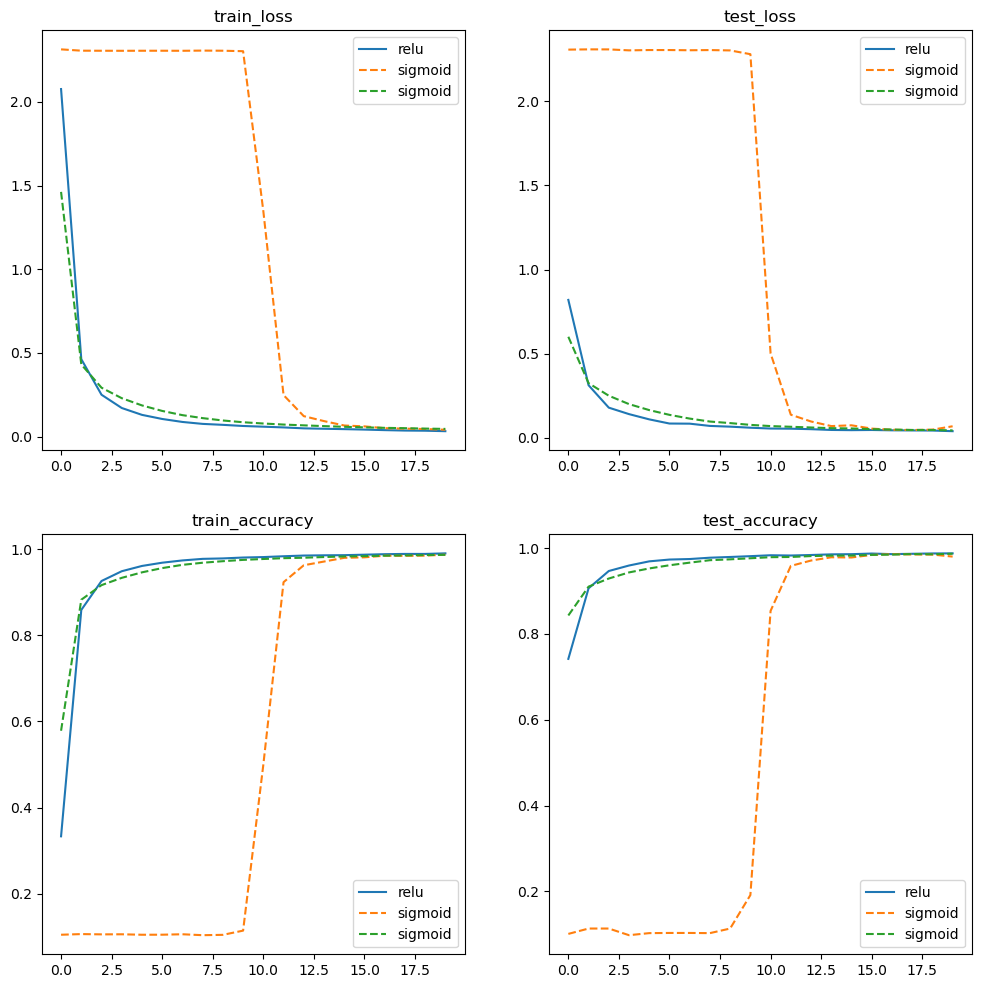

In [10]:
%matplotlib inline
plt.figure(figsize=(12,12))
fields = relu_result.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(relu_result[field], label="relu", linestyle="-")
    plt.plot(sigmoid_result[field], label="sigmoid", linestyle="--")
    plt.plot(tanh_result[field], label="sigmoid", linestyle="--")
    plt.legend()
    plt.title(field)

### 被错分的测试样本

In [12]:
from collections import namedtuple

WrongSamples = namedtuple("WrongSamples", "idx predicted_label gt_label")
wrong_samples = []
for idx in range(len(test_loader.dataset)):
    x, y = test_loader.dataset[idx]
    x = torch.unsqueeze(x, 0)
    x = x.to(DEVICE)
    net.eval()
    with torch.no_grad():
        logits = net(x)
        predicted_label = torch.argmax(logits, dim=1).item()
        if predicted_label != y:
            sample = WrongSamples(idx, predicted_label, y)
            wrong_samples.append(sample)

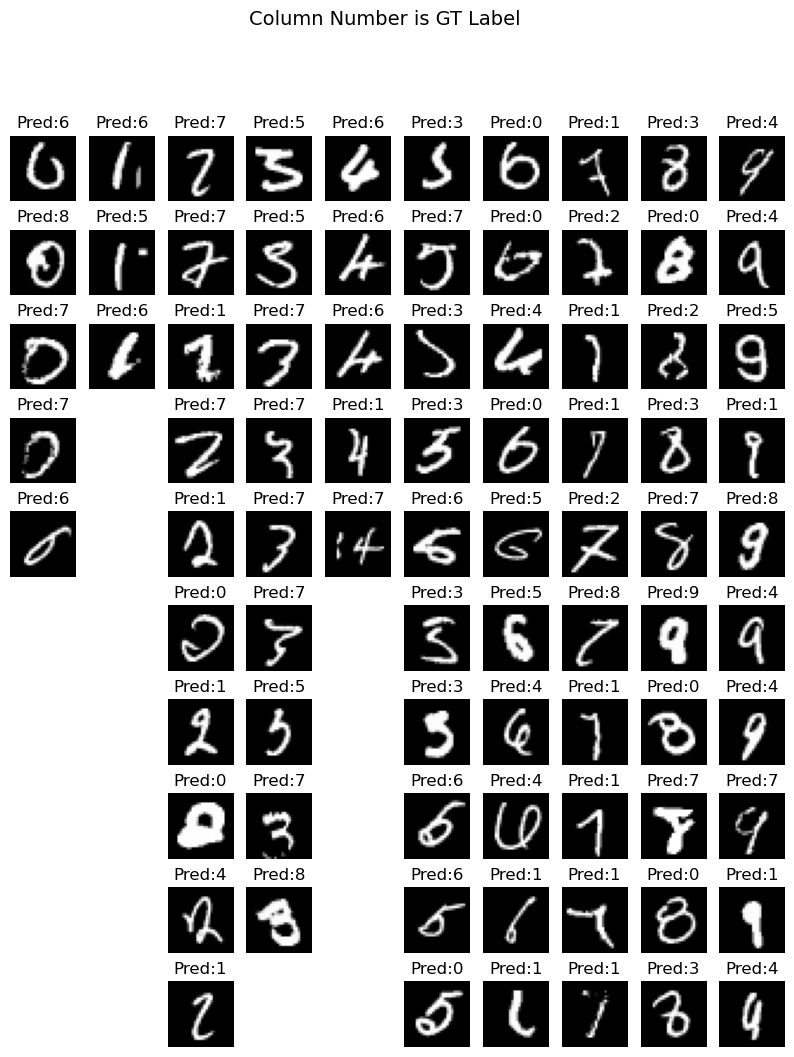

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(10,12))
fig = plt.gcf()
fig.suptitle("Column Number is GT Label", fontsize=14)
images_per_class = 10
per_class_image_count = defaultdict(int)
num_classes = 10
test_dataset = test_loader.dataset
for sample in wrong_samples:
    idx = sample.idx
    predicted_label = sample.predicted_label
    gt_label = sample.gt_label
    i = per_class_image_count[gt_label]
    if i >= images_per_class:
        continue
    per_class_image_count[gt_label] += 1
    plt_idx = i * num_classes + gt_label + 1
    plt.subplot(images_per_class, num_classes, plt_idx)
    image = test_dataset.data[idx,:,:]
    plt.imshow(image.squeeze())
    plt.axis("off")
    plt.title(f"Pred:{predicted_label}")
plt.show()